# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.888464,False,-2.203735
1,-2.241538,False,-5.664553
2,-0.334730,True,3.472955
3,-0.805488,True,4.624912
4,-1.273908,True,2.446185
...,...,...,...
995,0.007627,True,3.908976
996,-1.275785,True,3.397432
997,-2.530643,False,-6.360178
998,-0.037295,False,-0.975472


<AxesSubplot: xlabel='v0'>

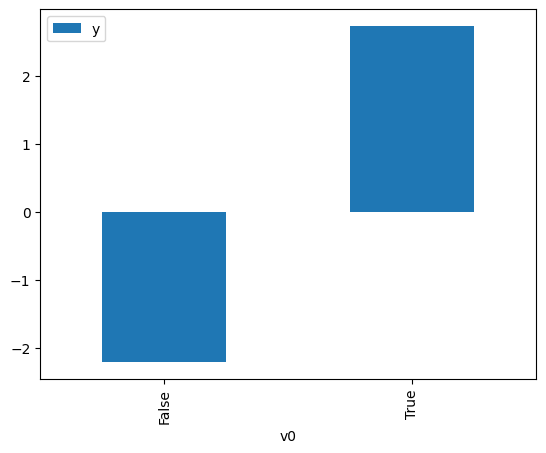

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

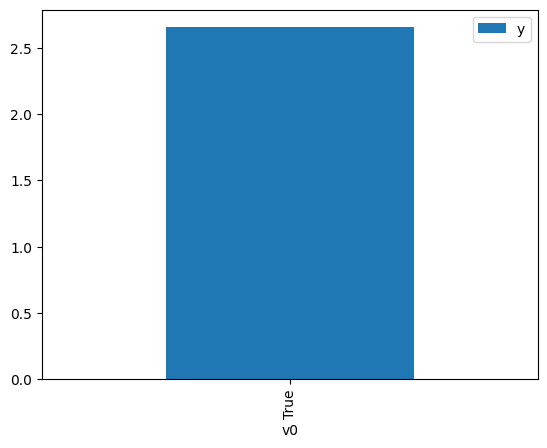

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-2.324818,False,-5.941996,0.523616,1.909795
1,-2.526898,False,-5.290295,0.524811,1.905446
2,-1.085529,False,-2.712633,0.516283,1.936924
3,-0.002015,False,1.022717,0.509865,1.961304
4,-1.892058,False,-4.826185,0.521057,1.919178
...,...,...,...,...,...
995,1.117849,False,3.966078,0.503228,1.987170
996,-2.437872,False,-5.129277,0.524285,1.907359
997,-0.830718,False,-0.813320,0.514774,1.942601
998,-0.784468,False,-2.374298,0.514500,1.943635


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-2.141391,True,-0.432370,0.477468,2.094379
1,-1.736128,True,3.263833,0.479866,2.083914
2,-1.531876,True,2.983172,0.481075,2.078678
3,-3.193084,True,-3.284117,0.471251,2.122011
4,-0.565808,True,3.321324,0.486795,2.054252
...,...,...,...,...,...
995,-0.021164,True,6.430860,0.490022,2.040726
996,-2.514195,True,-1.799160,0.475264,2.104095
997,-0.381239,True,3.049496,0.487889,2.049648
998,-0.130361,True,3.853389,0.489375,2.043424


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.933
Model:                            OLS   Adj. R-squared (uncentered):              0.933
Method:                 Least Squares   F-statistic:                              6931.
Date:                Fri, 10 Feb 2023   Prob (F-statistic):                        0.00
Time:                        04:46:01   Log-Likelihood:                         -1395.2
No. Observations:                1000   AIC:                                      2794.
Df Residuals:                     998   BIC:                                      2804.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.5798      0.026     99.645      0.000       2.529       2.631
x2             4.9937      0.050    100.637      0.000       4.896       5.091
==============================================================================
Omnibus:                        0.254   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.881   Jarque-Bera (JB):                0.284
Skew:                           0.038   Prob(JB):                        0.867
Kurtosis:                       2.967   Cond. No.                         2.29
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""